## **LSTM for Cloud Resource Metrics Forecasting**

**The model is designed to forecast key AWS resource metrics (EC2, RDS, and ECS CPU utilization) by leveraging historical cloud monitoring data.**

1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

2. Mount google drive (If needed)

In [2]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

3. Feature engineering

    * Extracts time-based features such as the hour of day and day of week.
    * Creates utilization ratios (e.g., EC2_CPU/MEM ratio).
    * Computes rolling means to smooth out fluctuations.
    * Creates lag features

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_lag_features(df, feature_cols, lag=3):
    for col in feature_cols:
        for i in range(1, lag + 1):
            df[f"{col}_lag{i}"] = df[col].shift(i)
    df.dropna(inplace=True)
    return df

def add_engineered_features(df, service):
    df = df.copy()
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.isna()]

    # Time-based features
    df.loc[:, 'hour'] = df.index.hour
    df.loc[:, 'day_of_week'] = df.index.dayofweek

    if service == 'EC2':
        df.loc[:, 'EC2_CPU_Memory_Ratio'] = np.clip(df['EC2_CPUUtilization'] / (df['EC2_MemoryUtilization'] + 1e-5), 0, 100)
        df.loc[:, 'EC2_CPU_rolling_mean'] = df['EC2_CPUUtilization'].rolling(window=5).mean()
    elif service == 'RDS':
        df.loc[:, 'RDS_Connections_Per_CPU'] = np.clip(df['RDS_DatabaseConnections'] / (df['RDS_CPUUtilization'] + 1e-5), 0, 100)
        df.loc[:, 'RDS_CPU_rolling_mean'] = df['RDS_CPUUtilization'].rolling(window=5).mean()
    elif service == 'ECS':
        df.loc[:, 'ECS_CPU_Memory_Ratio'] = np.clip(df['ECS_CPUUtilization'] / (df['ECS_MemoryUtilization'] + 1e-5), 0, 100)
        df.loc[:, 'ECS_Task_Rolling_Mean'] = df['ECS_RunningTaskCount'].rolling(window=5).mean()

    # Drop rows with NaN values after rolling calculations
    df.dropna(inplace=True)
    return df


4. Dataset class

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target_col, sequence_length=10):
        self.features = data[features].values
        self.targets = data[target_col].values
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx:idx+self.sequence_length]
        y = self.targets[idx+self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


5. LSTM Model Definition

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.35):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

6. Training the models

In [6]:
def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.0005, early_stop_patience=5, early_stop_start=15):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    # Scheduler with step size of 5 for more aggressive decay
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    
    model.to(device)
    best_val_loss = float('inf')
    patience = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        val_loss = evaluate_model(model, val_loader)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping check starting from early_stop_start epoch
        if epoch+1 >= early_stop_start:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
            if patience >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

7. Evaluate models

In [7]:
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            total_loss += criterion(y_pred, y_batch).item()
    return total_loss / len(val_loader)

def predict_and_evaluate(model, test_loader, target_scaler, target_feature):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            predictions.extend(y_pred)
            actuals.extend(y_batch.numpy())
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    predictions = target_scaler.inverse_transform(predictions)
    actuals = target_scaler.inverse_transform(actuals)
    
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    print(f"\nEvaluation for {target_feature}: MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}")
    
    # Plot prediction vs actual
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title(f"Prediction vs Actual for {target_feature}")
    plt.xlabel("Sample")
    plt.ylabel(target_feature)
    plt.legend()
    plt.show()
    
    results = pd.DataFrame({"Actual": actuals.flatten(), "Predicted": predictions.flatten()})
    results.to_csv(f"{target_feature}_predictions.csv", index=False)
    return mae, mse, rmse

8. Main process


=== Processing EC2 Dataset ===
EC2 - Target (EC2_CPUUtilization) mean: 49.9145, std: 28.8995
EC2 - Total features: 32
Evaluating EC2 model...

Evaluation for EC2_CPUUtilization: MAE=0.8663, MSE=1.0033, RMSE=1.0017


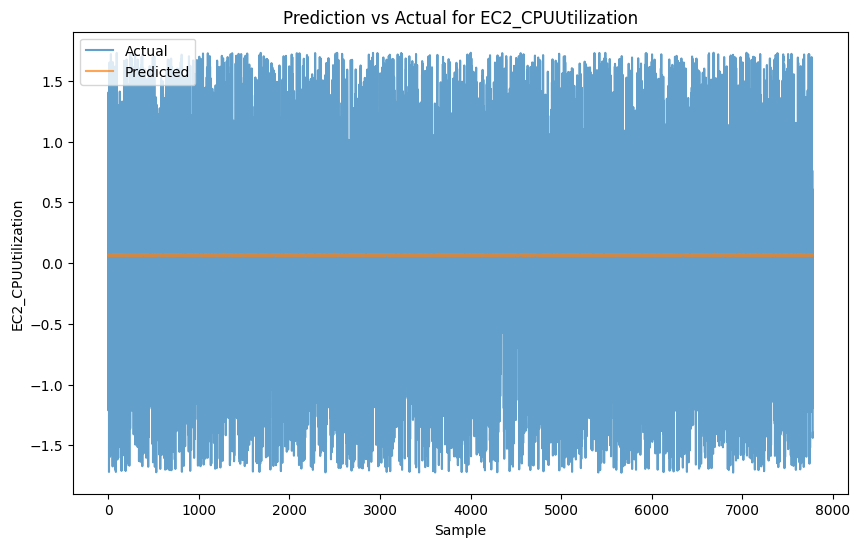


=== Processing RDS Dataset ===
RDS - Target (RDS_CPUUtilization) mean: 50.2432, std: 28.8641
RDS - Total features: 32
Evaluating RDS model...

Evaluation for RDS_CPUUtilization: MAE=0.8675, MSE=1.0068, RMSE=1.0034


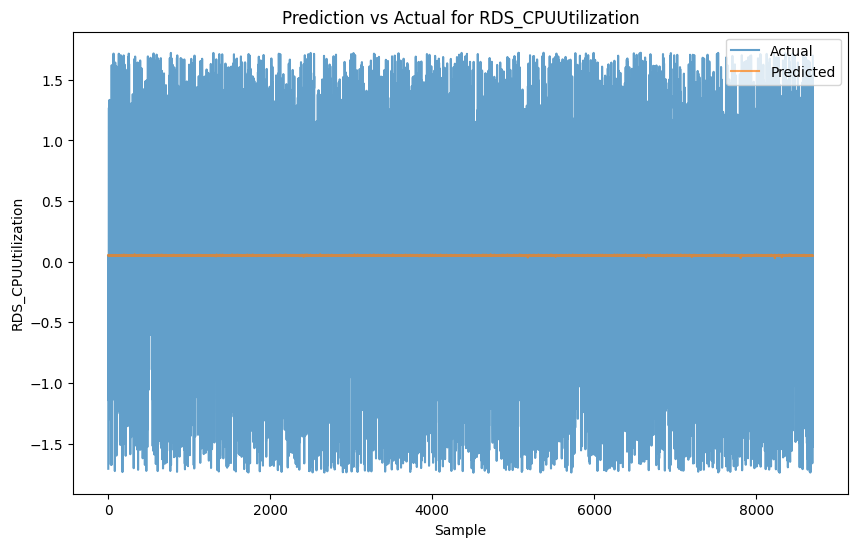


=== Processing ECS Dataset ===
ECS - Target (ECS_CPUUtilization) mean: 49.6995, std: 28.8797
ECS - Total features: 28
Evaluating ECS model...

Evaluation for ECS_CPUUtilization: MAE=0.8660, MSE=1.0011, RMSE=1.0005


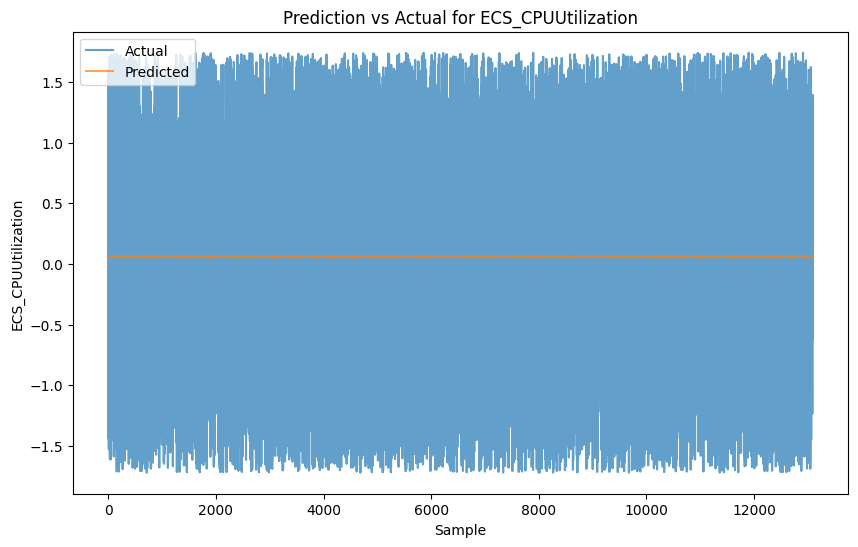


All models trained, evaluated, and saved!


In [10]:
dataset_info = {
    'EC2': {
        'path': "../dataset scripts/reduced_ec2_data.csv",
        'features': ['EC2_CPUUtilization', 'EC2_MemoryUtilization', 'EC2_DiskWriteOps', 'EC2_NetworkIn']
    },
    'RDS': {
        'path': "../dataset scripts/reduced_rds_data.csv",
        'features': ['RDS_CPUUtilization', 'RDS_FreeableMemory', 'RDS_DatabaseConnections', 'RDS_WriteIOPS']
    },
    'ECS': {
        'path': "../dataset scripts/reduced_ecs_data.csv",
        'features': ['ECS_CPUUtilization', 'ECS_MemoryUtilization', 'ECS_RunningTaskCount']
    }
}

# Additional engineered features for each service
engineered_features = {
    'EC2': ['hour', 'day_of_week', 'EC2_CPU_Memory_Ratio', 'EC2_CPU_rolling_mean'],
    'RDS': ['hour', 'day_of_week', 'RDS_Connections_Per_CPU', 'RDS_CPU_rolling_mean'],
    'ECS': ['hour', 'day_of_week', 'ECS_CPU_Memory_Ratio', 'ECS_Task_Rolling_Mean']
}

# Dictionary to store target scalers (one per service)
target_scalers = {}

sequence_length = 10
batch_size = 64
epochs = 50

for resource, info in dataset_info.items():
    print(f"\n=== Processing {resource} Dataset ===")
    df = pd.read_csv(info['path'], index_col=0)
    df.index = pd.to_datetime(df.index, errors='coerce')
    
    # Add engineered features
    df = add_engineered_features(df, resource)
    
    # Initial feature list: original + engineered
    base_features = info['features'] + engineered_features[resource]
    
    # Create lag features and update feature list
    df = create_lag_features(df, base_features, lag=3)
    features = [col for col in df.columns if col in base_features or any(col.startswith(f"{feat}_lag") for feat in base_features)]
    target_feature = info['features'][0]

    print(f"{resource} - Target ({target_feature}) mean: {df[target_feature].mean():.4f}, std: {df[target_feature].std():.4f}")
    print(f"{resource} - Total features: {len(features)}")  # Debug: Confirm feature count
    
    # Scale features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    df[features] = feature_scaler.fit_transform(df[features])
    df[target_feature] = target_scaler.fit_transform(df[[target_feature]])
    target_scalers[resource] = target_scaler

    # Create dataset and split
    dataset = TimeSeriesDataset(df, features, target_feature, sequence_length)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    # Train and save model
    model = LSTMModel(input_size=len(features))
    # print(f"Training {resource} model with input_size={len(features)}...")
    # train_model(model, train_loader, val_loader, epochs=epochs, learning_rate=0.0005)
    
    # model_path = f"{resource}_lstm_model.pth"
    # torch.save(model.state_dict(), model_path)
    # print(f"Saved {resource} model to {model_path}")
    
    # Evaluate
    print(f"Evaluating {resource} model...")
    predict_and_evaluate(model, val_loader, target_scalers[resource], target_feature)

print("\nAll models trained, evaluated, and saved!")

In [16]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the saved models and target scalers
def load_model(model_path, input_size):
    model = LSTMModel(input_size=input_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.to(device)
    model.eval()
    return model

# Define features for each resource (same as during training)
features_ec2 = ['EC2_CPUUtilization', 'EC2_MemoryUtilization', 'EC2_DiskWriteOps', 'EC2_NetworkIn', 
                'hour', 'day_of_week', 'EC2_CPU_Memory_Ratio', 'EC2_CPU_rolling_mean',
                'EC2_CPUUtilization_lag1', 'EC2_CPUUtilization_lag2', 'EC2_CPUUtilization_lag3',
                'EC2_MemoryUtilization_lag1', 'EC2_MemoryUtilization_lag2', 'EC2_MemoryUtilization_lag3',
                'EC2_DiskWriteOps_lag1', 'EC2_DiskWriteOps_lag2', 'EC2_DiskWriteOps_lag3',
                'EC2_NetworkIn_lag1', 'EC2_NetworkIn_lag2', 'EC2_NetworkIn_lag3']

features_rds = ['RDS_CPUUtilization', 'RDS_FreeableMemory', 'RDS_DatabaseConnections', 'RDS_WriteIOPS',
                'hour', 'day_of_week', 'RDS_Connections_Per_CPU', 'RDS_CPU_rolling_mean',
                'RDS_CPUUtilization_lag1', 'RDS_CPUUtilization_lag2', 'RDS_CPUUtilization_lag3',
                'RDS_FreeableMemory_lag1', 'RDS_FreeableMemory_lag2', 'RDS_FreeableMemory_lag3',
                'RDS_DatabaseConnections_lag1', 'RDS_DatabaseConnections_lag2', 'RDS_DatabaseConnections_lag3',
                'RDS_WriteIOPS_lag1', 'RDS_WriteIOPS_lag2', 'RDS_WriteIOPS_lag3']

features_ecs = ['ECS_CPUUtilization', 'ECS_MemoryUtilization', 'ECS_RunningTaskCount',
                'hour', 'day_of_week', 'ECS_CPU_Memory_Ratio', 'ECS_Task_Rolling_Mean',
                'ECS_CPUUtilization_lag1', 'ECS_CPUUtilization_lag2', 'ECS_CPUUtilization_lag3',
                'ECS_MemoryUtilization_lag1', 'ECS_MemoryUtilization_lag2', 'ECS_MemoryUtilization_lag3',
                'ECS_RunningTaskCount_lag1', 'ECS_RunningTaskCount_lag2', 'ECS_RunningTaskCount_lag3']

# Load models and scalers
ec2_model = load_model("../models/EC2_lstm_model.pth", input_size=len(features_ec2))
rds_model = load_model("../models/RDS_lstm_model.pth", input_size=len(features_rds))
ecs_model = load_model("../models/ECS_lstm_model.pth", input_size=len(features_ecs))

# Load target scalers (assuming they were saved earlier)
target_scalers = {
    'EC2': StandardScaler(),
    'RDS': StandardScaler(),
    'ECS': StandardScaler()
}

# Load the test data (assuming it's already preprocessed)
def load_test_data(resource):
    df = pd.read_csv(dataset_info[resource]['path'], index_col=0)
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = add_engineered_features(df, resource)
    base_features = dataset_info[resource]['features'] + engineered_features[resource]
    df = create_lag_features(df, base_features, lag=3)
    features = [col for col in df.columns if col in base_features or any(col.startswith(f"{feat}_lag") for feat in base_features)]
    target_feature = dataset_info[resource]['features'][0]
    return df, features, target_feature

# Function to plot actual vs predicted and calculate accuracy
def plot_and_evaluate(model, test_loader, target_scaler, target_feature, resource):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            predictions.extend(y_pred)
            actuals.extend(y_batch.numpy())
    
    # Inverse transform to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    predictions = target_scaler.inverse_transform(predictions)
    actuals = target_scaler.inverse_transform(actuals)
    
    # Calculate accuracy metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    print(f"\nEvaluation for {resource} - {target_feature}:")
    print(f"MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title(f"Actual vs Predicted for {resource} - {target_feature}")
    plt.xlabel("Sample")
    plt.ylabel(target_feature)
    plt.legend()
    plt.show()
    
    return mae, mse, rmse

# Process each resource
for resource in ['EC2', 'RDS', 'ECS']:
    print(f"\n=== Evaluating {resource} Model ===")
    df, features, target_feature = load_test_data(resource)
    
    # Scale features (target is already scaled during training)
    feature_scaler = StandardScaler()
    df[features] = feature_scaler.fit_transform(df[features])
    
    # Create dataset and loader
    dataset = TimeSeriesDataset(df, features, target_feature, sequence_length)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Load the appropriate model
    if resource == 'EC2':
        model = ec2_model
    elif resource == 'RDS':
        model = rds_model
    elif resource == 'ECS':
        model = ecs_model
    
    # Plot and evaluate
    plot_and_evaluate(model, test_loader, target_scalers[resource], target_feature, resource)

print("\nAll models evaluated and plotted!")

RuntimeError: Error(s) in loading state_dict for LSTMModel:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([1024, 32]) from checkpoint, the shape in current model is torch.Size([1024, 20]).